In [1]:
import CoolProp.CoolProp as CP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
# import itertools # Ya no necesario
import warnings
# from scipy.optimize import least_squares # Ya no necesario
# import math # Ya no necesario
import os # Para verificar existencia de archivo

Cargando datos del solver inverso desde: df_resultados_modelo_inverso_R22.csv
Se encontraron 100 resultados exitosos del solver en el CSV.

--- Realizando hasta 10 Comparaciones con Sim. Dinámica ---
UA_eff Estimado (fijo para todas las comparaciones): 1095.4 W/K

--- Comparación Punto 1/10 (CSV fila index 0) ---
Datos CSV: Tev=-7.31°C, Tcd=22.21°C, mdot=0.13281 kg/s
           Qev_target=24265.7 W, Wc_target=4056.1 W

--- Configuración Simulación Dinámica ---
Fluido: R22
Leche: 2009.7 kg, T_ini=30.3°C, T_fin=3.5°C
Control: T_evap_target=-5.0°C, T_cond_target=22.2°C
Compresor: eta_nom=0.75, Vel=[0.2-1.0], Pérdida Eta=0.10
Simulación: dt=1s, Max Time=5.0h, Puntos Salida Max=100
UA_eff Estimado (fijo): 1095.4 W/K
------------------------------------------
--- Iniciando Simulación Dinámica (Punto 1) ---
Setpoints: T_evap=-5.0°C, T_cond=22.2°C
Compresor: eta_nom=0.75, Rango Vel=[0.2-1.0], Pérdida Eta=0.10
Inicial Estimado: Q_evap≈38.67 kW, m_flow_nominal≈0.2105 kg/s (a vel=1.0, eta=0.75)
S

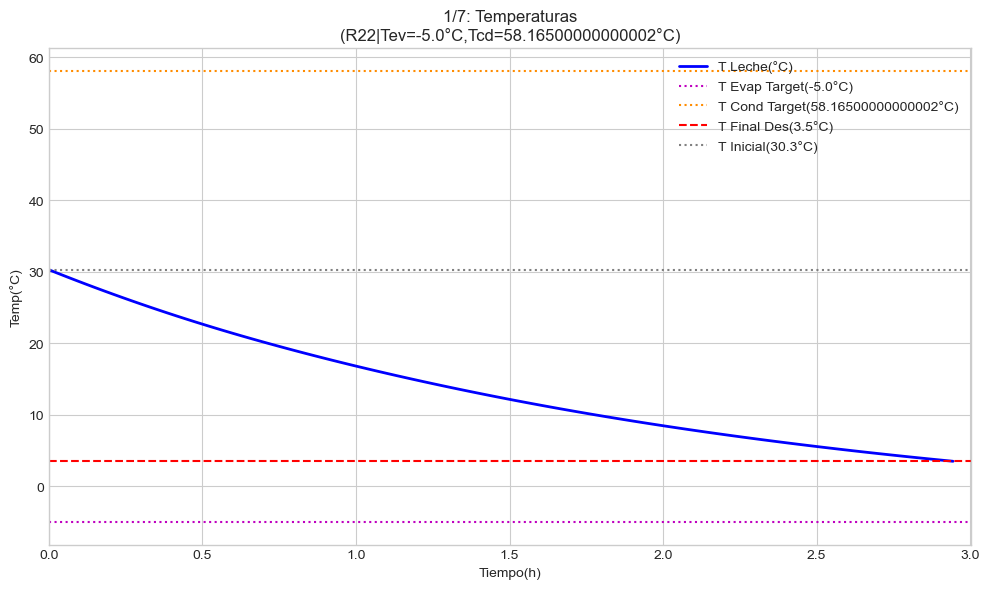

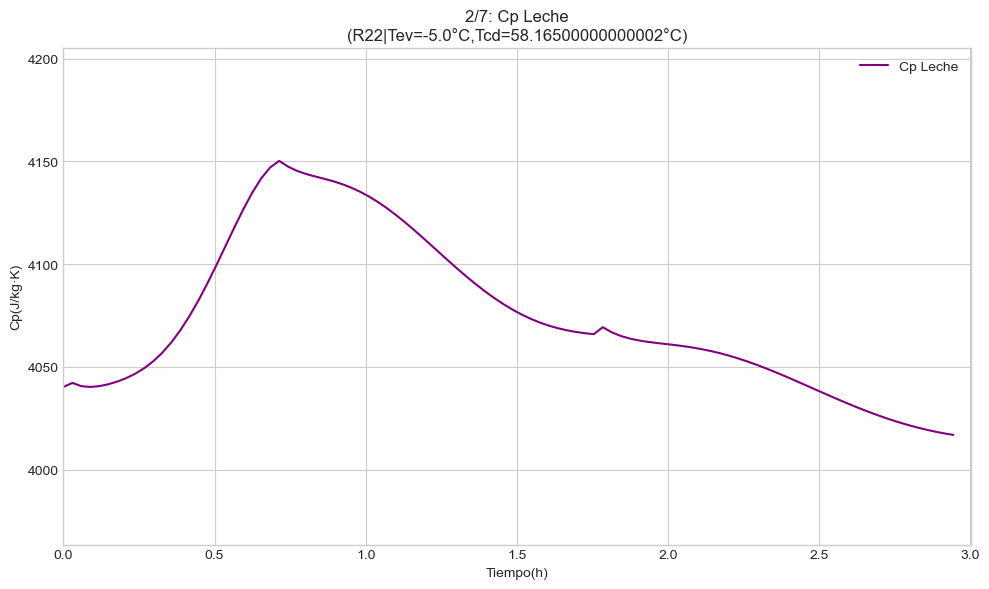

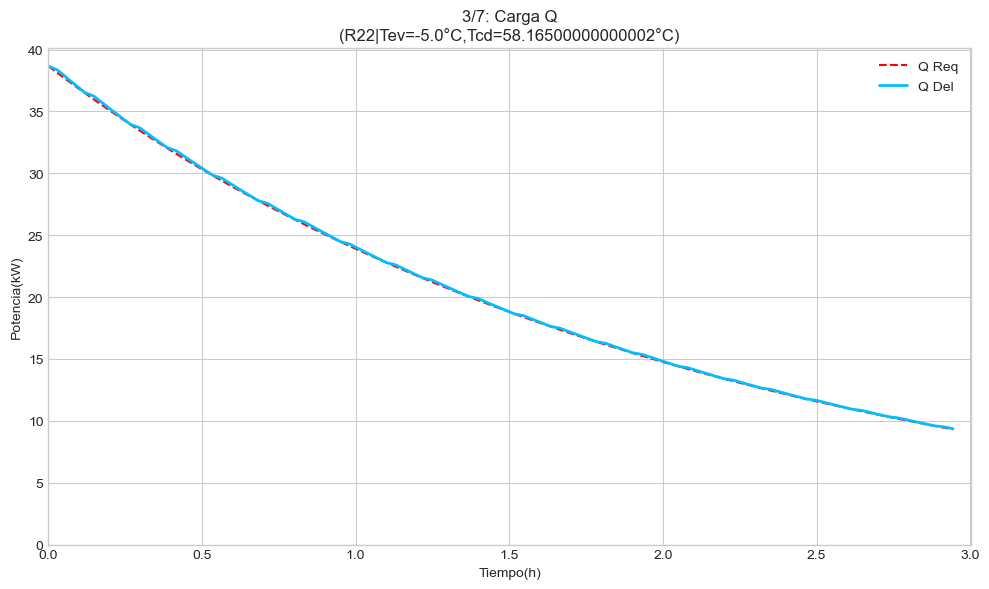

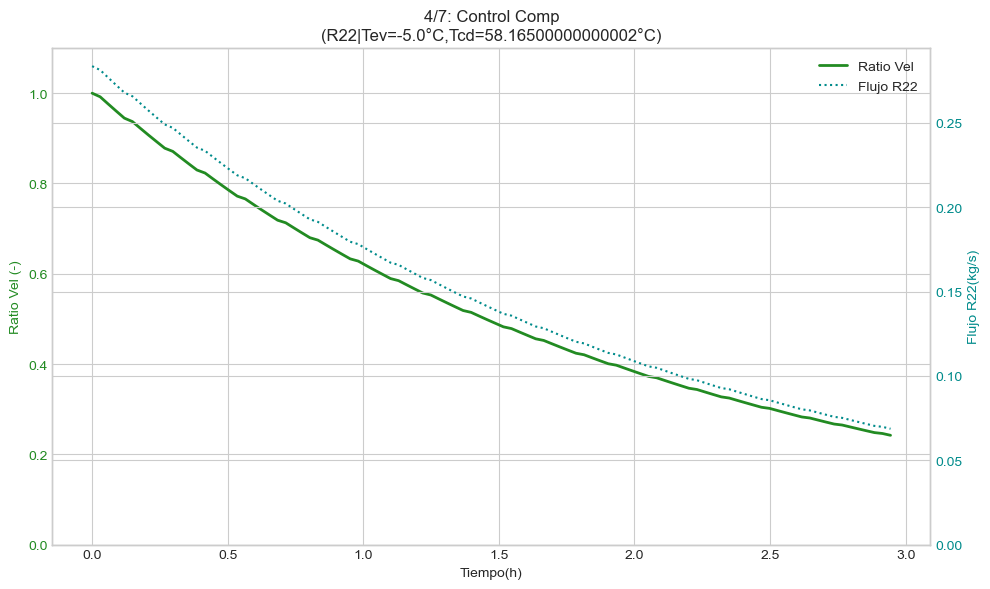

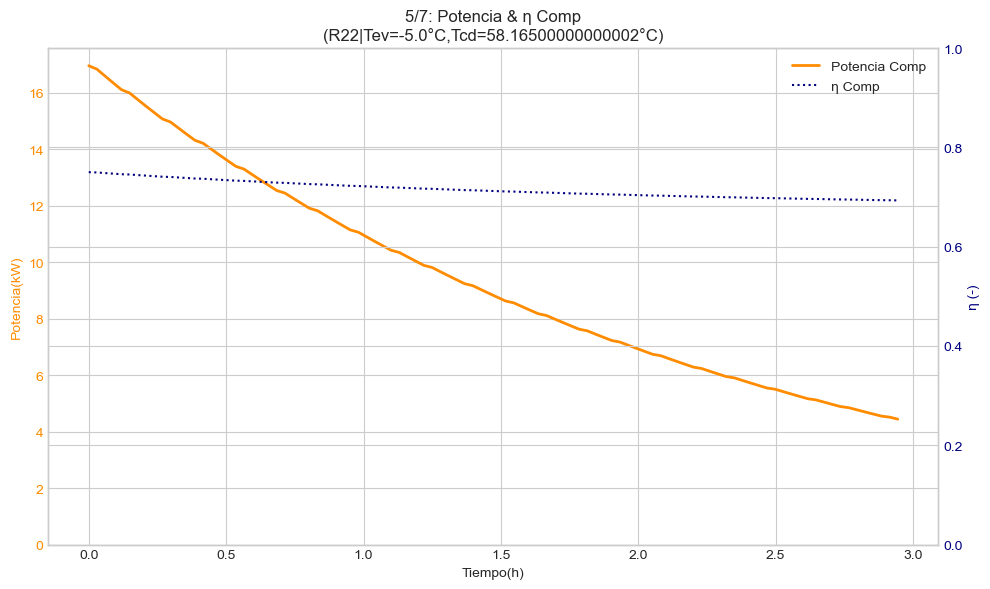

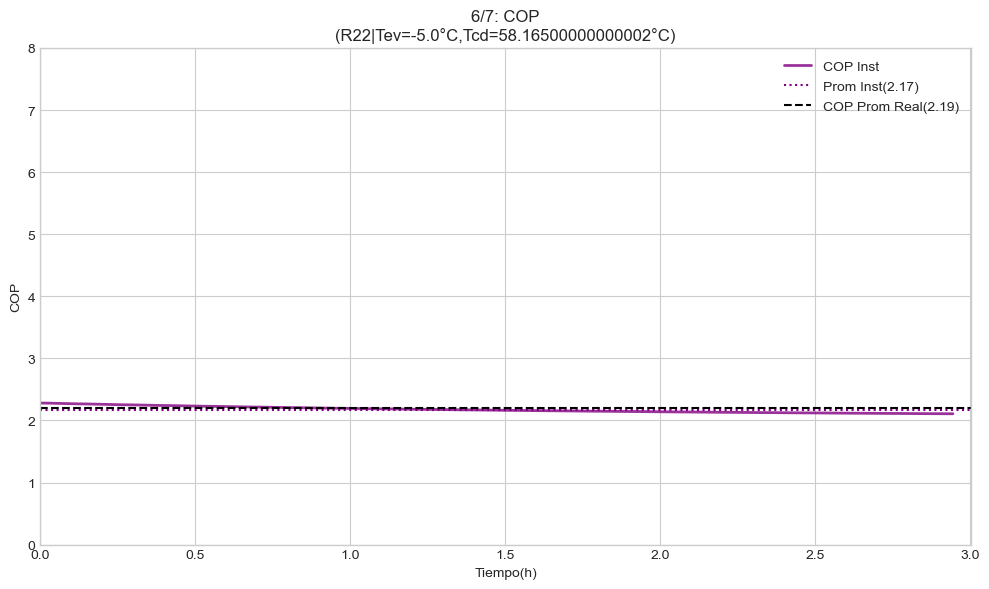

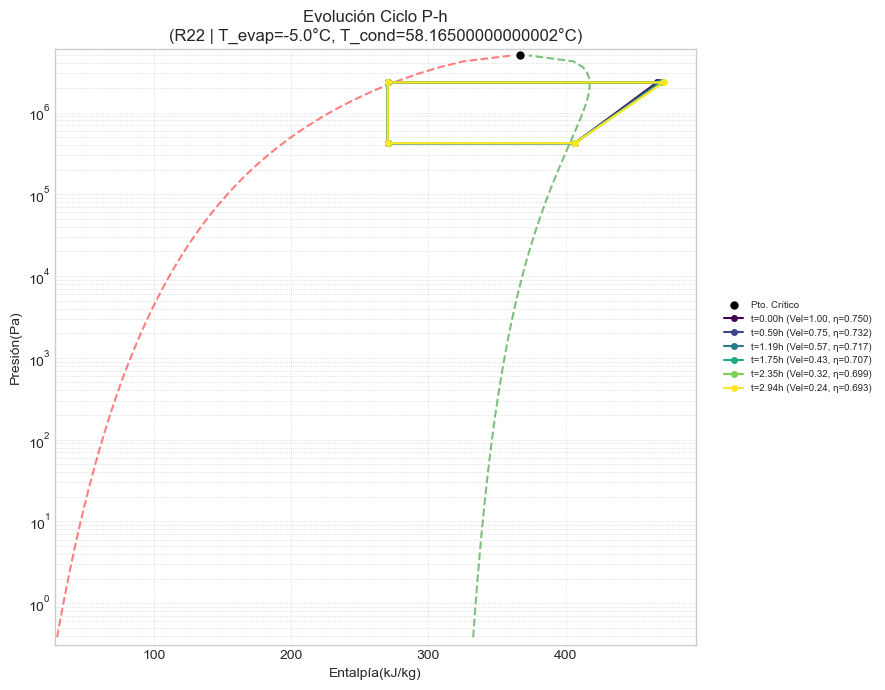


--- Fin del Script ---


In [2]:
# --- Función get_cp_milk (Sin cambios) ---
def get_cp_milk(T_C, fat_percent):
    """
    Calcula la capacidad calorífica específica aparente de la leche (J/kg·K)
    basado en la temperatura (T en °C) y el porcentaje de grasa (%).
    """
    cp_J_gK = None; T = T_C
    if abs(fat_percent - 3.5) < 0.1:
        # Correlaciones Polinómicas de Grado 5 (Cp en J/g·K, T en °C)
        if 0 <= T < 10:
            cp_J_gK = (1.76658466e-05*T**5 - 4.58836819e-04*T**4 + 4.04370224e-03*T**3 - 1.30139780e-02*T**2 + 1.33604567e-02*T + 4.01576359e+00)
        elif 10 <= T < 20:
            cp_J_gK = (6.22034295e-06*T**5 - 4.39825638e-04*T**4 + 1.20323308e-02*T**3 - 1.58521777e-01*T**2 + 1.01058292e+00*T + 1.55586850e+00)
        elif 20 <= T < 30:
            cp_J_gK = (8.57989556e-06*T**5 - 1.11106869e-03*T**4 + 5.72799853e-02*T**3 - 1.46758410e+00*T**2 + 1.86524283e+01*T - 8.97892159e+01)
        elif 30 <= T < 40:
            cp_J_gK = (3.70894294e-08*T**5 - 1.22027288e-05*T**4 + 1.48337059e-03*T**3 - 8.22247585e-02*T**2 + 2.10691612e+00*T - 1.62358505e+01)
    if cp_J_gK is None: return None
    if cp_J_gK <= 0:
        warnings.warn(f"Cp no positivo ({cp_J_gK:.3f}) T={T_C:.1f}, fat={fat_percent}. None.", stacklevel=3)
        return None
    return cp_J_gK * 1000.0

# --- Función get_thermo_cycle_properties (Sin cambios respecto a tu versión) ---
def get_thermo_cycle_properties(T_evap_C, T_cond_C, subcooling_K, eta_comp_dynamic, superheat_K, fluid):
    """ Calcula propiedades para ciclo subcrítico con T_cond y subenfriamiento. """
    try:
        T_evap_K = T_evap_C + 273.15
        T_cond_K = T_cond_C + 273.15 # Temperatura de condensación
        sc_K = subcooling_K       # Subenfriamiento

        T_crit_K = CP.PropsSI('Tcrit', fluid)
        T_max_fluid = CP.PropsSI('Tmax', fluid)
        T_min_fluid = CP.PropsSI('Tmin', fluid)

        # Validaciones básicas de temperatura
        if not (T_min_fluid < T_evap_K < T_crit_K - 0.1): return None
        if not (T_evap_K < T_cond_K < T_crit_K - 0.1): return None # Asegura subcrítico y Tcond > Tevap

        # --- Punto 1: Salida Evaporador / Entrada Compresor (Vapor sobrecalentado) ---
        P1_Pa = CP.PropsSI('P', 'T', T_evap_K, 'Q', 1, fluid)
        T1_K = T_evap_K + superheat_K
        if T1_K >= T_max_fluid: return None
        h1_J_kg = CP.PropsSI('H', 'T', T1_K, 'P', P1_Pa, fluid)
        s1_J_kgK = CP.PropsSI('S', 'T', T1_K, 'P', P1_Pa, fluid)

        # --- Punto 3: Salida Condensador / Entrada Válvula (Líquido subenfriado) ---
        P_cond_Pa = CP.PropsSI('P', 'T', T_cond_K, 'Q', 0, fluid) # Presión de condensación
        P3_Pa = P_cond_Pa
        T3_K = T_cond_K - sc_K # Aplicar subenfriamiento
        if T3_K <= T_evap_K or T3_K <= T_min_fluid : return None # T3 debe ser mayor que Tevap y Tmin
        h3_J_kg = CP.PropsSI('H', 'T', T3_K, 'P', P3_Pa, fluid)
        s3_J_kgK = CP.PropsSI('S', 'T', T3_K, 'P', P3_Pa, fluid)

        # --- Punto 2: Salida Compresor (Vapor sobrecalentado) ---
        P2_Pa = P3_Pa # La presión es la de condensación
        s2s = s1_J_kgK # Entropía isentrópica
        h2s = CP.PropsSI('H', 'P', P2_Pa, 'S', s2s, fluid) # Entalpía isentrópica
        if not (0 < eta_comp_dynamic <= 1.0): eta_comp_dynamic = 0.7 # Fallback
        h2_J_kg = h1_J_kg + (h2s - h1_J_kg) / eta_comp_dynamic # Entalpía real
        try:
            T2_K = CP.PropsSI('T', 'P', P2_Pa, 'H', h2_J_kg, fluid)
            if T2_K >= T_max_fluid: return None
        except ValueError: return None
        s2_J_kgK = CP.PropsSI('S', 'P', P2_Pa, 'H', h2_J_kg, fluid)

        # --- Punto 4: Salida Válvula / Entrada Evaporador (Mezcla L-V) ---
        P4_Pa = P1_Pa # Presión de evaporación
        h4_J_kg = h3_J_kg # Expansión isoentálpica
        try:
            T4_K = CP.PropsSI('T', 'P', P4_Pa, 'H', h4_J_kg, fluid)
            if not (T_min_fluid < T4_K < T_max_fluid): return None
        except ValueError: return None
        s4_J_kgK = CP.PropsSI('S', 'P', P4_Pa, 'H', h4_J_kg, fluid)

        # --- Deltas ---
        delta_h_evap_J_kg = h1_J_kg - h4_J_kg
        delta_h_comp_J_kg = h2_J_kg - h1_J_kg
        delta_h_cond_J_kg = h2_J_kg - h3_J_kg # Calor rechazado en condensador+desobrecalentador
        if delta_h_evap_J_kg <= 1e-3 or delta_h_comp_J_kg <= 0: return None

        # --- Propiedades ---
        cycle_props = {
            'T_evap_K_calc': T_evap_K, 'T_cond_K_calc': T_cond_K, # Guardamos las T usadas
            'T1_K': T1_K, 'P1_Pa': P1_Pa, 'h1_J_kg': h1_J_kg, 's1_J_kgK': s1_J_kgK,
            'T2_K': T2_K, 'P2_Pa': P2_Pa, 'h2_J_kg': h2_J_kg, 's2_J_kgK': s2_J_kgK,
            'T3_K': T3_K, 'P3_Pa': P3_Pa, 'h3_J_kg': h3_J_kg, 's3_J_kgK': s3_J_kgK,
            'T4_K': T4_K, 'P4_Pa': P4_Pa, 'h4_J_kg': h4_J_kg, 's4_J_kgK': s4_J_kgK,
            'delta_h_evap_J_kg': delta_h_evap_J_kg,
            'delta_h_comp_J_kg': delta_h_comp_J_kg,
            'delta_h_cond_J_kg': delta_h_cond_J_kg, # Delta H condensador
            'eta_comp_used': eta_comp_dynamic,
            'valid': True
        }
        for i in [1, 2, 3, 4]:
            try: xi=CP.PropsSI('Q','P',cycle_props[f'P{i}_Pa'],'H',cycle_props[f'h{i}_J_kg'],fluid); cycle_props[f'x{i}']=xi if (0<=xi<=1) else np.nan
            except: cycle_props[f'x{i}']=np.nan
        return cycle_props
    except (ValueError, Exception) as e: return None


# --- Función Principal de Simulación (MODIFICADA para salida de 100 puntos) ---
def run_dynamic_cooling_simulation(control_params, milk_props, sim_settings, system_params, num_output_points=100):
    """
    Ejecuta simulación dinámica OPTIMIZADA para ciclo subcrítico (T_cond, sc).
    Recalcula ciclo termodinámico cada 'cycle_recalc_interval' segundos.
    Devuelve arrays con 'num_output_points' puntos muestreados de la simulación.
    """
    # --- Extracción de parámetros ---
    T_evap_C_target = control_params['T_evap_C_target']
    T_cond_C_target = control_params['T_cond_C_target']
    T_evap_K_target = T_evap_C_target + 273.15
    T_cond_K_target = T_cond_C_target + 273.15
    m_milk = milk_props['m_milk']; fat_percent = milk_props['fat_percent']
    cp_milk_avg_fallback = milk_props['cp_milk_avg']
    T_milk_initial_K = milk_props['T_milk_initial_K']; T_milk_final_K = milk_props['T_milk_final_K']
    UA_eff = sim_settings['UA_eff']; dt = sim_settings['dt']; max_sim_time_s = sim_settings['max_sim_time_s']
    eta_comp_nominal = system_params['eta_comp_nominal']; superheat_K = system_params['superheat_K']
    subcooling_K = system_params['subcooling_K']
    fluid = system_params['fluid']; min_speed_ratio = system_params.get('min_speed_ratio', 0.2)
    max_speed_ratio = system_params.get('max_speed_ratio', 1.0); eta_loss_factor = system_params.get('eta_loss_factor', 0.1)
    cycle_recalc_interval = system_params.get('cycle_recalc_interval', 60)

    # --- Inicialización ---
    initial_cycle_props = get_thermo_cycle_properties(T_evap_C_target, T_cond_C_target, subcooling_K,
                                                     eta_comp_nominal, superheat_K, fluid)
    if initial_cycle_props is None: return {'success': False, 'reason': 'Ciclo inicial inválido'}
    delta_h_evap_nominal = initial_cycle_props['delta_h_evap_J_kg']
    Q_evap_initial = UA_eff * (T_milk_initial_K - T_evap_K_target)
    if Q_evap_initial <= 0: return {'success': False, 'reason': 'Carga inicial no positiva'}
    m_flow_nominal = Q_evap_initial / delta_h_evap_nominal if delta_h_evap_nominal > 0 else 0
    if m_flow_nominal <= 0: return {'success': False, 'reason': 'm_flow_nominal inválido'}

    # --- Listas de Datos (almacenarán la simulación COMPLETA) ---
    time_data_full=[0.0]; T_milk_data_K_full=[T_milk_initial_K]; cp_milk_data_full=[]
    Q_req_data_W_full=[Q_evap_initial]; Q_del_data_W_full=[Q_evap_initial]; m_flow_data_full=[m_flow_nominal]
    speed_ratio_data_full=[max_speed_ratio]; eta_comp_data_full=[eta_comp_nominal]; power_comp_data_W_full=[]
    inst_cop_data_full=[]
    Q_cond_data_W_full = []
    # Usar un diccionario para simplificar el manejo de listas de ciclo
    cycle_data_full = {f'{prop}{i}': [] for i in range(1, 5) for prop in ['T', 'P', 'h']}

    # --- Cálculos Iniciales ---
    initial_T_C=T_milk_initial_K-273.15; initial_cp=get_cp_milk(initial_T_C,fat_percent)
    cp_milk_data_full.append(initial_cp if initial_cp is not None else cp_milk_avg_fallback)
    initial_power=m_flow_nominal*initial_cycle_props.get('delta_h_comp_J_kg', np.nan)
    power_comp_data_W_full.append(initial_power)
    initial_cop=Q_evap_initial/initial_power if initial_power>1e-6 else np.nan
    inst_cop_data_full.append(initial_cop)
    initial_q_cond = m_flow_nominal * initial_cycle_props.get('delta_h_cond_J_kg', np.nan)
    Q_cond_data_W_full.append(initial_q_cond)
    for i in range(1, 5):
        cycle_data_full[f'T{i}'].append(initial_cycle_props.get(f'T{i}_K',np.nan))
        cycle_data_full[f'P{i}'].append(initial_cycle_props.get(f'P{i}_Pa',np.nan))
        cycle_data_full[f'h{i}'].append(initial_cycle_props.get(f'h{i}_J_kg',np.nan))

    # --- Variables de Simulación ---
    current_T_milk_K=T_milk_initial_K; current_t_s=0.0; total_energy_J=0.0; simulation_success=False; warned_about_cp=False
    last_cycle_props=initial_cycle_props; delta_h_evap_actual=delta_h_evap_nominal
    delta_h_comp_actual=initial_cycle_props.get('delta_h_comp_J_kg', np.nan)
    delta_h_cond_actual=initial_cycle_props.get('delta_h_cond_J_kg', np.nan)
    last_recalc_time=-cycle_recalc_interval; last_eta_comp_used = eta_comp_nominal; speed_ratio = max_speed_ratio

    # --- Bucle de Simulación Dinámica (OPTIMIZADO) ---
    while current_t_s < max_sim_time_s:
        if current_T_milk_K <= T_milk_final_K: simulation_success = True; break
        delta_T_evap = current_T_milk_K - T_evap_K_target
        if delta_T_evap <= 1e-3: simulation_success=abs(current_T_milk_K-T_milk_final_K)<0.5; break

        needs_recalc = (current_t_s == 0 or (current_t_s - last_recalc_time) >= cycle_recalc_interval - dt*0.5)
        Q_evap_required = UA_eff * delta_T_evap

        if needs_recalc:
            m_flow_required = Q_evap_required / delta_h_evap_nominal if delta_h_evap_nominal > 0 else 0
            speed_ratio = m_flow_required / m_flow_nominal if m_flow_nominal > 0 else 0
            speed_ratio = np.clip(speed_ratio, min_speed_ratio, max_speed_ratio)
            eta_comp_dynamic = eta_comp_nominal * (1.0 - eta_loss_factor * (1.0 - speed_ratio))
            eta_comp_dynamic = np.clip(eta_comp_dynamic, 0.1, 1.0)

            current_cycle_props = get_thermo_cycle_properties(T_evap_C_target, T_cond_C_target, subcooling_K,
                                                             eta_comp_dynamic, superheat_K, fluid)
            if current_cycle_props is None:
                warnings.warn(f"Fallo recálculo ciclo t={current_t_s:.0f}s. Usando último válido.", stacklevel=2)
                last_recalc_time = current_t_s # Update time even if failed to avoid spamming warnings
                # Keep using the last valid 'last_cycle_props' and its deltas
            else:
                last_cycle_props = current_cycle_props
                delta_h_evap_actual = last_cycle_props.get('delta_h_evap_J_kg', delta_h_evap_actual)
                delta_h_comp_actual = last_cycle_props.get('delta_h_comp_J_kg', delta_h_comp_actual)
                delta_h_cond_actual = last_cycle_props.get('delta_h_cond_J_kg', delta_h_cond_actual)
                last_recalc_time = current_t_s
                last_eta_comp_used = last_cycle_props.get('eta_comp_used', eta_comp_dynamic)
        else:
            eta_comp_dynamic = last_eta_comp_used # Use efficiency from last successful recalc

        # --- Usar valores actuales/últimos ---
        current_m_flow = m_flow_nominal * speed_ratio # Usa el speed_ratio más reciente
        Q_evap_delivered = current_m_flow * delta_h_evap_actual
        current_power_comp_W = current_m_flow * delta_h_comp_actual
        current_Q_cond_W = current_m_flow * delta_h_cond_actual

        current_T_milk_C=current_T_milk_K-273.15; cp_milk_dynamic=get_cp_milk(current_T_milk_C,fat_percent)
        if cp_milk_dynamic is None:
            if not warned_about_cp: warnings.warn(f"Cp falló T={current_T_milk_C:.1f}C.", stacklevel=2); warned_about_cp=True
            cp_milk_dynamic = cp_milk_avg_fallback
        if cp_milk_dynamic<=0: return {'success':False,'reason':'Cp inválido'}
        if m_milk<=1e-6: return {'success':False,'reason':'Masa leche inválida'}
        delta_T_milk=-(Q_evap_delivered*dt)/(m_milk*cp_milk_dynamic)
        current_T_milk_K+=delta_T_milk; current_t_s+=dt; total_energy_J+=current_power_comp_W*dt

        # --- Almacenar datos (en listas completas) ---
        time_data_full.append(current_t_s); T_milk_data_K_full.append(current_T_milk_K); cp_milk_data_full.append(cp_milk_dynamic)
        Q_req_data_W_full.append(Q_evap_required); Q_del_data_W_full.append(Q_evap_delivered); m_flow_data_full.append(current_m_flow)
        speed_ratio_data_full.append(speed_ratio); eta_comp_data_full.append(eta_comp_dynamic) # Eta usada este paso
        power_comp_data_W_full.append(current_power_comp_W)
        inst_cop=Q_evap_delivered/current_power_comp_W if current_power_comp_W>1e-6 else np.nan; inst_cop_data_full.append(inst_cop)
        Q_cond_data_W_full.append(current_Q_cond_W)
        # Guarda ciclo (el último válido calculado)
        for i in range(1, 5):
            cycle_data_full[f'T{i}'].append(last_cycle_props.get(f'T{i}_K', np.nan))
            cycle_data_full[f'P{i}'].append(last_cycle_props.get(f'P{i}_Pa', np.nan))
            cycle_data_full[f'h{i}'].append(last_cycle_props.get(f'h{i}_J_kg', np.nan))

    # --- Fin Bucle ---

    # --- Procesamiento y Empaquetado (MODIFICADO PARA MUESTREO) ---
    n_steps = len(time_data_full) # Número total de puntos calculados
    if n_steps == 0: return {'success':False, 'reason':'Simulación no generó pasos'}

    # Determinar los índices a muestrear (máximo num_output_points)
    num_points_to_sample = min(n_steps, num_output_points)
    if n_steps == 1: # Caso especial: solo el punto inicial
        indices_100 = np.array([0], dtype=int)
    else:
        # Usamos round para mejor distribución y evitar duplicados si num_points_to_sample < n_steps
        indices_100 = np.round(np.linspace(0, n_steps - 1, num=num_points_to_sample)).astype(int)
        # Asegurarse de que los índices son únicos (linspace puede redondear al mismo índice a veces)
        indices_100 = np.unique(indices_100)
        # Si unique reduce el número de puntos, no importa, es mejor que tener duplicados exactos.

    print(f"Simulación completada con {n_steps} pasos. Muestreando {len(indices_100)} puntos.")

    # Convertir listas completas a arrays temporales para facilitar indexación
    time_full_arr = np.array(time_data_full)
    T_milk_K_full_arr = np.array(T_milk_data_K_full)
    cp_milk_full_arr = np.array(cp_milk_data_full)
    Q_req_W_full_arr = np.array(Q_req_data_W_full)
    Q_del_W_full_arr = np.array(Q_del_data_W_full)
    m_flow_full_arr = np.array(m_flow_data_full)
    speed_ratio_full_arr = np.array(speed_ratio_data_full)
    eta_comp_full_arr = np.array(eta_comp_data_full)
    power_comp_W_full_arr = np.array(power_comp_data_W_full)
    inst_cop_full_arr = np.array(inst_cop_data_full)
    Q_cond_W_full_arr = np.array(Q_cond_data_W_full)
    cycle_arrays_full = {key: np.array(val) for key, val in cycle_data_full.items()}

    # Seleccionar datos usando los índices
    time_sampled = time_full_arr[indices_100]
    T_milk_K_sampled = T_milk_K_full_arr[indices_100]
    cp_milk_sampled = cp_milk_full_arr[indices_100]
    Q_req_W_sampled = Q_req_W_full_arr[indices_100]
    Q_del_W_sampled = Q_del_W_full_arr[indices_100]
    m_flow_sampled = m_flow_full_arr[indices_100]
    speed_ratio_sampled = speed_ratio_full_arr[indices_100]
    eta_comp_sampled = eta_comp_full_arr[indices_100]
    power_comp_W_sampled = power_comp_W_full_arr[indices_100]
    inst_cop_sampled = inst_cop_full_arr[indices_100]
    Q_cond_W_sampled = Q_cond_W_full_arr[indices_100]
    cycle_arrays_sampled = {key: arr[indices_100] for key, arr in cycle_arrays_full.items()}


    # Calcular resultados finales basados en la simulación COMPLETA (no la muestreada)
    final_time_s = time_full_arr[-1]
    final_T_milk_K = T_milk_K_full_arr[-1]

    if not simulation_success and final_time_s >= max_sim_time_s - dt/2: # Usar -dt/2 por precisión flotante
        return {'success':False,'reason':f'Tiempo máx. {max_sim_time_s/3600:.1f}h excedido, Tfinal={final_T_milk_K-273.15:.1f}°C'}
    if not simulation_success:
        T_milk_final_C_local = T_milk_final_K - 273.15
        return {'success':False,'reason':f'Detenido prematuro, T={final_T_milk_K-273.15:.1f}°C != {T_milk_final_C_local:.1f}°C'}

    # Cálculos agregados sobre datos COMPLETOS
    avg_power_kW = (total_energy_J / final_time_s / 1000.0) if final_time_s > 0 else 0
    total_energy_kWh = total_energy_J / 3.6e6
    # Usar trapecio sobre datos COMPLETOS para mejor precisión del COP promedio
    Q_total_delivered_J = np.trapz(y=Q_del_W_full_arr, x=time_full_arr) if len(time_full_arr) > 1 else 0
    avg_system_COP_real = Q_total_delivered_J / total_energy_J if total_energy_J > 0 else np.nan

    # Crear diccionario de resultados con los ARRAYS MUESTREADOS
    results = {
        'success': True,
        'control_params': control_params,
        'final_time_s': final_time_s, # Tiempo final de la simulación completa
        'total_energy_kWh': total_energy_kWh, # Energía total de la simulación completa
        'final_T_milk_C': final_T_milk_K - 273.15, # Temp final de la simulación completa
        'avg_power_kW': avg_power_kW, # Potencia promedio de la simulación completa
        'avg_system_COP_real': avg_system_COP_real, # COP promedio de la simulación completa
        'num_original_steps': n_steps, # Guardamos cuántos pasos se calcularon originalmente
        'num_sampled_points': len(indices_100), # Y cuántos puntos se retornan

        # --- Arrays Muestreados ---
        'time_s': time_sampled,
        'T_milk_C': T_milk_K_sampled - 273.15,
        'cp_milk_dynamic': cp_milk_sampled,
        'Q_req_kW': Q_req_W_sampled / 1000.0,
        'Q_del_kW': Q_del_W_sampled / 1000.0,
        'm_flow_kg_s': m_flow_sampled,
        'speed_ratio': speed_ratio_sampled,
        'eta_comp_dynamic': eta_comp_sampled,
        'power_comp_kW': power_comp_W_sampled / 1000.0,
        'inst_COP': inst_cop_sampled,
        'Q_cond_kW': Q_cond_W_sampled / 1000.0,

        # Propiedades termodinámicas muestreadas
        'T1_K_series': cycle_arrays_sampled['T1'], 'P1_Pa_series': cycle_arrays_sampled['P1'], 'h1_Jkg_series': cycle_arrays_sampled['h1'],
        'T2_K_series': cycle_arrays_sampled['T2'], 'P2_Pa_series': cycle_arrays_sampled['P2'], 'h2_Jkg_series': cycle_arrays_sampled['h2'],
        'T3_K_series': cycle_arrays_sampled['T3'], 'P3_Pa_series': cycle_arrays_sampled['P3'], 'h3_Jkg_series': cycle_arrays_sampled['h3'],
        'T4_K_series': cycle_arrays_sampled['T4'], 'P4_Pa_series': cycle_arrays_sampled['P4'], 'h4_Jkg_series': cycle_arrays_sampled['h4'],
    }

    # Crear el DataFrame 'thermo_evolution_df' usando los MISMOS índices muestreados
    # Nota: El código original usaba min(n_steps, 20). Ahora usará los hasta 100 puntos muestreados.
    thermo_evo_data = {'Tiempo (s)': results['time_s']} # Usar el tiempo ya muestreado
    for i in range(1, 5):
        thermo_evo_data[f'T{i}(K)'] = results[f'T{i}_K_series']
        thermo_evo_data[f'P{i}(Pa)'] = results[f'P{i}_Pa_series']
        thermo_evo_data[f'h{i}(J/kg)'] = results[f'h{i}_Jkg_series']
    results['thermo_evolution_df'] = pd.DataFrame(thermo_evo_data)

    return results


# --- Función plot_ph_evolution (Como estaba antes, verifica que esté definida antes de usarla) ---
def plot_ph_evolution(results, system_params_plot, n_cycles_to_plot=5):
    if not results or not results['success']: print("No P-h: Resultados inválidos."); return
    fluid = system_params_plot['fluid']; control_params = results['control_params']
    title_suffix=f"({fluid} | ";
    if 'T_evap_C_target' in control_params: title_suffix+=f"T_evap={control_params['T_evap_C_target']}°C, "
    if 'T_cond_C_target' in control_params: title_suffix+=f"T_cond={control_params['T_cond_C_target']}°C, "
    if 'P_gc_Pa' in control_params: title_suffix+=f"P_gc={control_params['P_gc_Pa']/1e6:.2f}MPa, "
    if 'T_gc_out_C' in control_params: title_suffix+=f"T_gc_out={control_params['T_gc_out_C']}°C"
    scenario_title=title_suffix.strip().strip(',')+")"
    time_s = results['time_s']; n_steps = len(time_s);
    if n_steps == 0: print("No hay datos para graficar P-h."); return
    # Asegurar que n_cycles_to_plot no sea mayor que los puntos disponibles
    n_cycles_actual = min(n_cycles_to_plot, n_steps)
    if n_cycles_actual == 0: print("No hay ciclos para graficar P-h."); return
    indices = np.round(np.linspace(0, n_steps - 1, num=n_cycles_actual)).astype(int)
    indices = np.unique(indices) # Asegurar unicidad

    plt.figure(f"Evolución Ciclo P-h {scenario_title}", figsize=(11, 7))
    try: # Campana saturación
        P_crit=CP.PropsSI('Pcrit',fluid); P_triple=CP.PropsSI('ptriple',fluid); P_sat=np.logspace(np.log10(P_triple*1.01),np.log10(P_crit*0.999),100); h_liq=np.array([CP.PropsSI('H','P',p,'Q',0,fluid) for p in P_sat])/1000; h_vap=np.array([CP.PropsSI('H','P',p,'Q',1,fluid) for p in P_sat])/1000; T_crit=CP.PropsSI('Tcrit',fluid); h_crit=CP.PropsSI('H','T',T_crit,'P',P_crit,fluid)/1000; plt.plot(h_liq,P_sat,'r--',label='_nolegend_',lw=1.5,alpha=0.5); plt.plot(h_vap,P_sat,'g--',label='_nolegend_',lw=1.5,alpha=0.5); plt.plot(h_crit,P_crit,'ko',markersize=5,label='Pto. Crítico')
    except Exception as e: print(f"Adv: No campana: {e}")
    colors = plt.cm.viridis(np.linspace(0,1,len(indices))); all_h_points=[]; all_P_points=[]
    for i, idx in enumerate(indices): # Graficar ciclos seleccionados
        h_Jkg=np.array([results[f'h{j}_Jkg_series'][idx] for j in [1,2,3,4,1]]); P_Pa=np.array([results[f'P{j}_Pa_series'][idx] for j in [1,2,3,4,1]]); valid=np.isfinite(h_Jkg)&np.isfinite(P_Pa); h_kJkg=h_Jkg[valid]/1000.0; P_Pa_v=P_Pa[valid]
        if len(h_kJkg)>=4: t_h=time_s[idx]/3600.0; spd=results['speed_ratio'][idx]; eta=results['eta_comp_dynamic'][idx]; plt.plot(h_kJkg, P_Pa_v,'o-',color=colors[i],lw=1.5,ms=4,label=f't={t_h:.2f}h (Vel={spd:.2f}, η={eta:.3f})'); all_h_points.extend(h_kJkg); all_P_points.extend(P_Pa_v)
    plt.xlabel('Entalpía(kJ/kg)'); plt.ylabel('Presión(Pa)'); plt.yscale('log'); plt.title(f'Evolución Ciclo P-h\n{scenario_title}'); plt.legend(loc='center left',bbox_to_anchor=(1.03,0.5),fontsize=7); plt.grid(True,which="both",ls=':',lw=0.5)
    try:
        if all_h_points and all_P_points: # Check if lists are not empty
            h_min_data=min(all_h_points); h_max_data=max(all_h_points)
            P_min_data=min(all_P_points); P_max_data=max(all_P_points)
            h_min_liq = h_liq.min() if 'h_liq' in locals() and h_liq.size > 0 else h_min_data
            h_max_vap = h_vap.max() if 'h_vap' in locals() and h_vap.size > 0 else h_max_data
            P_min_sat = P_sat.min() if 'P_sat' in locals() and P_sat.size > 0 else P_min_data
            P_max_crit = P_crit if 'P_crit' in locals() else P_max_data

            h_min=min(h_min_data, h_min_liq)*0.95; h_max=max(h_max_data, h_max_vap)*1.05;
            P_min=min(P_min_data, P_min_sat)*0.8; P_max=max(P_max_data, P_max_crit)*1.2;
            plt.xlim(h_min,h_max); plt.ylim(P_min,P_max)
    except Exception as e: print(f"Error setting plot limits: {e}"); pass;
    plt.tight_layout(rect=[0,0,0.82,1])

# -- Función de Graficación Principal (Como estaba antes, verifica que esté definida antes de usarla) ---
def plot_dynamic_simulation_results(results, system_params_plot, T_milk_initial_C, T_milk_final_C):
    if not results or not results['success']: print("No gráficas: Inválido."); return
    control_params=results['control_params']; fluid=system_params_plot['fluid']
    title_suffix=f"({fluid}|";
    if'T_evap_C_target' in control_params: title_suffix+=f"Tev={control_params['T_evap_C_target']}°C,"
    if'T_cond_C_target' in control_params: title_suffix+=f"Tcd={control_params['T_cond_C_target']}°C"
    scenario_title=title_suffix.strip().strip(',')+")"
    time_h=results['time_s']/3600.0; n_plots=7;
    if time_h.size == 0: print("No hay datos para graficar resultados dinámicos."); return
    try:
      plt.style.use('seaborn-v0_8-whitegrid')
    except OSError:
      print("Estilo 'seaborn-v0_8-whitegrid' no encontrado, usando estilo por defecto.")
      pass # Usa el estilo por defecto si el especificado no está disponible
    # Gráfica 1: Temperaturas
    fig1,ax1=plt.subplots(figsize=(10,6)); fig1.canvas.manager.set_window_title(f"1/{n_plots} Temperaturas {scenario_title}")
    ax1.plot(time_h,results['T_milk_C'],label='T Leche(°C)',lw=2,c='blue'); ax1.axhline(y=control_params.get('T_evap_C_target',np.nan),c='m',ls=':',label=f'T Evap Target({control_params.get("T_evap_C_target","N/A")}°C)')
    if'T_cond_C_target' in control_params: ax1.axhline(y=control_params['T_cond_C_target'],c='darkorange',ls=':',label=f'T Cond Target({control_params["T_cond_C_target"]}°C)')
    ax1.axhline(y=T_milk_final_C,c='r',ls='--',label=f'T Final Des({T_milk_final_C}°C)'); ax1.axhline(y=T_milk_initial_C,c='grey',ls=':',label=f'T Inicial({T_milk_initial_C}°C)')
    ax1.set_xlabel('Tiempo(h)'); ax1.set_ylabel('Temp(°C)'); ax1.set_title(f'1/{n_plots}: Temperaturas\n{scenario_title}'); ax1.grid(True); ax1.set_xlim(left=0,right=max(time_h)*1.02 if time_h.size>0 else 1); ax1.legend(loc='best'); fig1.tight_layout()
    # Gráfica 2: Cp Leche
    plt.figure(f"2/{n_plots} Cp Leche {scenario_title}",figsize=(10,6)); plt.plot(time_h,results['cp_milk_dynamic'],label='Cp Leche',c='purple',ls='-'); plt.xlabel('Tiempo(h)'); plt.ylabel('Cp(J/kg·K)'); plt.title(f'2/{n_plots}: Cp Leche\n{scenario_title}'); plt.grid(True); plt.xlim(left=0,right=max(time_h)*1.02 if time_h.size>0 else 1);
    if results['cp_milk_dynamic'].size>0: min_cp,max_cp=np.nanmin(results['cp_milk_dynamic']),np.nanmax(results['cp_milk_dynamic']); plt.ylim(bottom=(min_cp-(max_cp-min_cp)*0.1 if abs(max_cp-min_cp)>1e-1 else min_cp-50)*0.99, top=(max_cp+(max_cp-min_cp)*0.1 if abs(max_cp-min_cp)>1e-1 else max_cp+50)*1.01)
    plt.legend(); plt.tight_layout()
    # Gráfica 3: Carga Q
    plt.figure(f"3/{n_plots} Carga Q {scenario_title}",figsize=(10,6)); plt.plot(time_h,results['Q_req_kW'],label='Q Req',c='r',ls='--',lw=1.5); plt.plot(time_h,results['Q_del_kW'],label='Q Del',c='deepskyblue',lw=2); plt.xlabel('Tiempo(h)'); plt.ylabel('Potencia(kW)'); plt.title(f'3/{n_plots}: Carga Q\n{scenario_title}'); plt.legend(); plt.grid(True); plt.ylim(bottom=0); plt.xlim(left=0,right=max(time_h)*1.02 if time_h.size>0 else 1); plt.tight_layout()
    # Gráfica 4: Control Compresor
    fig4,ax4a=plt.subplots(figsize=(10,6)); fig4.canvas.manager.set_window_title(f"4/{n_plots} Control Comp {scenario_title}"); ax4a.plot(time_h,results['speed_ratio'],label='Ratio Vel',c='forestgreen',lw=2); ax4a.set_xlabel('Tiempo(h)'); ax4a.set_ylabel('Ratio Vel (-)',c='forestgreen'); ax4a.tick_params(axis='y',labelcolor='forestgreen'); ax4a.set_ylim(0,1.1); ax4a.grid(True); ax4b=ax4a.twinx(); ax4b.plot(time_h,results['m_flow_kg_s'],label=f'Flujo {fluid}',c='darkcyan',ls=':'); ax4b.set_ylabel(f'Flujo {fluid}(kg/s)',c='darkcyan'); ax4b.tick_params(axis='y',labelcolor='darkcyan'); ax4b.set_ylim(bottom=0); plt.title(f'4/{n_plots}: Control Comp\n{scenario_title}'); lines1,labels1=ax4a.get_legend_handles_labels(); lines2,labels2=ax4b.get_legend_handles_labels(); ax4a.legend(lines1+lines2,labels1+labels2,loc='best'); fig4.tight_layout()
    # Gráfica 5: Potencia/Eficiencia Compresor
    fig5,ax5a=plt.subplots(figsize=(10,6)); fig5.canvas.manager.set_window_title(f"5/{n_plots} Potencia Comp {scenario_title}"); ax5a.plot(time_h,results['power_comp_kW'],label='Potencia Comp',c='darkorange',lw=2); ax5a.set_xlabel('Tiempo(h)'); ax5a.set_ylabel('Potencia(kW)',c='darkorange'); ax5a.tick_params(axis='y',labelcolor='darkorange'); ax5a.set_ylim(bottom=0); ax5a.grid(True); ax5b=ax5a.twinx(); ax5b.plot(time_h,results['eta_comp_dynamic'],label='η Comp',c='navy',ls=':'); ax5b.set_ylabel('η (-)',c='navy'); ax5b.tick_params(axis='y',labelcolor='navy'); ax5b.set_ylim(0,1.0); plt.title(f'5/{n_plots}: Potencia & η Comp\n{scenario_title}'); lines1,labels1=ax5a.get_legend_handles_labels(); lines2,labels2=ax5b.get_legend_handles_labels(); ax5a.legend(lines1+lines2,labels1+labels2,loc='best'); fig5.tight_layout()
    # Gráfica 6: COP
    plt.figure(f"6/{n_plots} COP {scenario_title}",figsize=(10,6)); valid_cop_mask=np.isfinite(results['inst_COP'])&(results['inst_COP']>0)&(results['inst_COP']<20); valid_time_h=time_h[valid_cop_mask]; valid_inst_cop=results['inst_COP'][valid_cop_mask];
    if len(valid_inst_cop)>0: plt.plot(valid_time_h,valid_inst_cop,label='COP Inst',c='purple',lw=2,alpha=0.8); mean_inst_cop=np.mean(valid_inst_cop); plt.axhline(y=mean_inst_cop,c='purple',ls=':',label=f'Prom Inst({mean_inst_cop:.2f})')
    plt.axhline(y=results['avg_system_COP_real'],c='black',ls='--',label=f'COP Prom Real({results["avg_system_COP_real"]:.2f})'); plt.xlabel('Tiempo(h)'); plt.ylabel('COP'); plt.title(f'6/{n_plots}: COP\n{scenario_title}'); plt.legend(); plt.grid(True); plt.ylim(bottom=0,top=max(valid_inst_cop.max()*1.1 if len(valid_inst_cop)>0 else 0,results.get('avg_system_COP_real',0)*1.2,8.0)); plt.xlim(left=0,right=max(time_h)*1.02 if time_h.size>0 else 1); plt.tight_layout()
    # Gráfica 7: Evolución P-h
    plot_ph_evolution(results, system_params_plot, n_cycles_to_plot=6)
    plt.show()

# ==============================================================================
# --- SECCIÓN PRINCIPAL DE EJECUCIÓN (CON MODIFICACIÓN PARA T_evap FIJA Y NUEVOS PRINTS) ---
# ==============================================================================
if __name__ == "__main__":

    # --- Inputs Principales (Leche) ---
    V_milk_liters = 1950.0 # Litros
    rho_milk = 1.0306      # kg/L o 1030.6 kg/m^3 (asumiendo densidad en kg/L)
    T_milk_initial_C = 30.3 # °C
    T_milk_final_C = 3.5   # °C
    fat_percent = 3.5      # %
    t_cool_desired_hours = 3.0 # Tiempo máximo deseado para el enfriamiento en horas

    # --- Parámetros del Sistema R22 y Simulación ---
    ETA_COMP_NOMINAL = 0.75
    SUPERHEAT_K = 5.0
    SUBCOOLING_K = 3.0
    FLUID = 'R22' # Cambia a 'R744' si usas CO2, o al fluido que necesites
    MIN_SPEED_RATIO = 0.2; MAX_SPEED_RATIO = 1.0; ETA_LOSS_FACTOR = 0.1
    DT = 1 ; CYCLE_RECALC_INTERVAL = 60; MAX_SIM_TIME_HOURS = 5.0; max_sim_time_s = MAX_SIM_TIME_HOURS*3600
    NUM_OUTPUT_POINTS_TARGET = 100 # <<< Objetivo de puntos de salida

    # *** CRITERIOS DE REPRESENTATIVIDAD ***
    MDOT_REL_DIFF_THRESHOLD = 0.15
    WC_REL_DIFF_THRESHOLD = 0.15

    # --- Nombre del archivo CSV y número de puntos a comparar ---
    csv_filename = 'df_resultados_modelo_inverso_R22.csv' # Asegúrate que el nombre coincida
    num_comparisons = 10 # Puedes ajustar esto

    # --- Cargar datos del CSV ---
    # (El código de carga del CSV permanece igual que en tu versión original)
    if not os.path.exists(csv_filename):
        print(f"ERROR: No se encontró el archivo CSV '{csv_filename}'. No se puede comparar.")
        df_csv_results = None
    else:
        print(f"Cargando datos del solver inverso desde: {csv_filename}")
        try:
            df_csv_results = pd.read_csv(csv_filename)
            required_cols = ['T_evap_K', 'T_cond_K', 'm_dot_kgs', 'Q_evap_Target', 'W_comp_Target']
            if not all(col in df_csv_results.columns for col in required_cols):
                print(f"ERROR: El CSV debe contener las columnas: {required_cols}")
                df_csv_results = None
            else:
                success_filter = True
                if 'Meets_Tolerance' in df_csv_results.columns: success_filter &= (df_csv_results['Meets_Tolerance'] == True)
                elif 'Solver_Success' in df_csv_results.columns: success_filter &= (df_csv_results['Solver_Success'] == True)
                # Asegurar que el filtro sea una Serie booleana válida antes de aplicarlo
                if isinstance(success_filter, pd.Series) or isinstance(success_filter, np.ndarray) or isinstance(success_filter, list):
                    df_csv_results = df_csv_results[success_filter].copy()
                elif not success_filter : # Si success_filter terminó siendo False
                    df_csv_results = pd.DataFrame(columns=df_csv_results.columns) # Dataframe vacío

                if df_csv_results.empty: print("ADVERTENCIA: No se encontraron resultados exitosos del solver en el CSV."); df_csv_results = None
                else: print(f"Se encontraron {len(df_csv_results)} resultados exitosos del solver en el CSV.")
        except Exception as e: print(f"ERROR al leer/procesar CSV '{csv_filename}': {e}"); df_csv_results = None


    # --- Bucle de Comparación ---
    comparison_summary = []
    representative_count = 0
    comparison_points_run = 0
    dynamic_results = None # Inicializar para que exista fuera del bucle

    if df_csv_results is not None:
        print(f"\n--- Realizando hasta {num_comparisons} Comparaciones con Sim. Dinámica ---")
        num_available = len(df_csv_results)
        num_to_run = min(num_comparisons, num_available)
        if num_to_run == 0:
            print("No hay datos válidos en el CSV para comparar.")
        else:
            indices_csv = np.round(np.linspace(0, num_available - 1, num=num_to_run)).astype(int)
            indices_csv = np.unique(indices_csv) # Asegurar unicidad
            if len(indices_csv) < num_comparisons: print(f"ADVERTENCIA: Usando solo {len(indices_csv)} puntos del CSV.")

            # Calcular UA_eff una vez (y otras props fijas)
            m_milk = V_milk_liters * rho_milk # Asumiendo rho_milk en kg/L
            T_milk_initial_K = T_milk_initial_C + 273.15
            T_milk_final_K = T_milk_final_C + 273.15
            T_avg_C = (T_milk_initial_C + T_milk_final_C) / 2.0
            cp_milk_avg_J_kgK = get_cp_milk(T_avg_C, fat_percent)
            if cp_milk_avg_J_kgK is None:
                 # Fallback si get_cp_milk falla para la T promedio
                 cp_milk_avg_J_kgK = get_cp_milk(15, fat_percent) # Intentar con una T común
                 if cp_milk_avg_J_kgK is None: cp_milk_avg_J_kgK = 4000.0 # Último recurso
                 warnings.warn(f"Cp leche promedio falló T={T_avg_C:.1f}C. Usando fallback={cp_milk_avg_J_kgK:.1f} J/kgK", stacklevel=2)
            Q_total_est = m_milk * cp_milk_avg_J_kgK * (T_milk_initial_K - T_milk_final_K)
            t_cool_desired_s = t_cool_desired_hours * 3600
            Q_avg_est_W = Q_total_est / t_cool_desired_s if t_cool_desired_s > 0 else 0
            UA_eff = 1500.0 # UA inicial de respaldo

            # Usar T_evap FIJA para estimar UA_eff
            TARGET_T_EVAP_C_for_UA = -5.0 # <---- Usa la T_evap fija para calcular UA_eff
            try:
                if Q_avg_est_W > 0:
                    T_evap_ref_K = TARGET_T_EVAP_C_for_UA + 273.15
                    dT1 = T_milk_initial_K - T_evap_ref_K
                    dT2 = T_milk_final_K - T_evap_ref_K
                    if dT1 > 1e-3 and dT2 > 1e-3:
                        LMTD = (dT1 - dT2) / np.log(dT1 / dT2) if abs(dT1 - dT2) > 1e-3 else (dT1 + dT2) / 2.0
                        if LMTD > 0: UA_eff = Q_avg_est_W / LMTD
            except Exception as e_ua: print(f"Advertencia calculando UA_eff: {e_ua}")
            print(f"UA_eff Estimado (fijo para todas las comparaciones): {UA_eff:.1f} W/K")

            # Preparar diccionarios de parámetros fijos (para la simulación)
            milk_properties = {'m_milk': m_milk, 'fat_percent': fat_percent, 'cp_milk_avg': cp_milk_avg_J_kgK, 'T_milk_initial_K': T_milk_initial_K, 'T_milk_final_K': T_milk_final_K}
            simulation_settings = {'UA_eff': UA_eff, 'dt': DT, 'max_sim_time_s': max_sim_time_s}
            system_parameters = {'eta_comp_nominal': ETA_COMP_NOMINAL, 'superheat_K': SUPERHEAT_K, 'subcooling_K': SUBCOOLING_K, 'fluid': FLUID, 'min_speed_ratio': MIN_SPEED_RATIO, 'max_speed_ratio': MAX_SPEED_RATIO, 'eta_loss_factor': ETA_LOSS_FACTOR, 'cycle_recalc_interval': CYCLE_RECALC_INTERVAL}


            for i, csv_idx in enumerate(indices_csv):
                print("\n" + "="*40 + f"\n--- Comparación Punto {i+1}/{len(indices_csv)} (CSV fila index {csv_idx}) ---\n" + "="*40)
                row_csv = df_csv_results.iloc[csv_idx] # Usar iloc

                T_evap_K_csv = row_csv['T_evap_K']; T_cond_K_csv = row_csv['T_cond_K']; m_dot_csv = row_csv['m_dot_kgs']
                Q_evap_target_csv = row_csv['Q_evap_Target']; W_comp_target_csv = row_csv['W_comp_Target']

                if pd.isna(T_evap_K_csv) or pd.isna(T_cond_K_csv) or pd.isna(m_dot_csv) or pd.isna(Q_evap_target_csv) or pd.isna(W_comp_target_csv):
                    print("ERROR: Datos inválidos en CSV para este punto. Saltando."); continue

                print(f"Datos CSV: Tev={T_evap_K_csv-273.15:.2f}°C, Tcd={T_cond_K_csv-273.15:.2f}°C, mdot={m_dot_csv:.5f} kg/s")
                print(f"           Qev_target={Q_evap_target_csv:.1f} W, Wc_target={W_comp_target_csv:.1f} W")

                # --- MODIFICACIÓN: FIJAR T_evap y T_cond de control ---
                TARGET_T_EVAP_C = -5.0  # <--- ¡Fuerza la temperatura del evaporador!
                TARGET_T_COND_C = T_cond_K_csv - 273.15 # Mantiene T_cond del CSV

                control_parameters = {
                    'T_evap_C_target': TARGET_T_EVAP_C,
                    'T_cond_C_target': TARGET_T_COND_C
                }
                # --- FIN MODIFICACIÓN ---

                # --- INICIO: NUEVO BLOQUE DE IMPRESIÓN - Configuración ---
                print("\n--- Configuración Simulación Dinámica ---")
                print(f"Fluido: {FLUID}")
                print(f"Leche: {milk_properties['m_milk']:.1f} kg, T_ini={T_milk_initial_C}°C, T_fin={T_milk_final_C}°C")
                # Ajustar print de control según sea subcrítico o transcrítico si se adapta el código
                print(f"Control: T_evap_target={control_parameters['T_evap_C_target']:.1f}°C, T_cond_target={control_parameters['T_cond_C_target']:.1f}°C")
                print(f"Compresor: eta_nom={system_parameters['eta_comp_nominal']:.2f}, Vel=[{system_parameters['min_speed_ratio']:.1f}-{system_parameters['max_speed_ratio']:.1f}], Pérdida Eta={system_parameters['eta_loss_factor']:.2f}")
                print(f"Simulación: dt={simulation_settings['dt']}s, Max Time={max_sim_time_s/3600:.1f}h, Puntos Salida Max={NUM_OUTPUT_POINTS_TARGET}")
                print(f"UA_eff Estimado (fijo): {simulation_settings['UA_eff']:.1f} W/K")
                print("------------------------------------------")
                # --- FIN: NUEVO BLOQUE DE IMPRESIÓN - Configuración ---

                # --- INICIO: NUEVO BLOQUE DE IMPRESIÓN - Inicio Simulación ---
                print(f"--- Iniciando Simulación Dinámica (Punto {i+1}) ---")
                print(f"Setpoints: T_evap={control_parameters['T_evap_C_target']:.1f}°C, T_cond={control_parameters['T_cond_C_target']:.1f}°C")
                print(f"Compresor: eta_nom={system_parameters['eta_comp_nominal']:.2f}, Rango Vel=[{system_parameters['min_speed_ratio']:.1f}-{system_parameters['max_speed_ratio']:.1f}], Pérdida Eta={system_parameters['eta_loss_factor']:.2f}")

                # Calcular Q_evap_initial y m_flow_nominal para la impresión (similar a como se hace dentro de la sim)
                q_initial_calc = 0.0
                m_flow_nom_calc = 0.0
                try:
                    # Usar el eta nominal para este cálculo inicial
                    initial_cycle_props_for_print = get_thermo_cycle_properties(control_parameters['T_evap_C_target'],
                                                                                control_parameters['T_cond_C_target'],
                                                                                system_parameters['subcooling_K'],
                                                                                system_parameters['eta_comp_nominal'], # Eta Nominal
                                                                                system_parameters['superheat_K'],
                                                                                system_parameters['fluid'])
                    if initial_cycle_props_for_print:
                        delta_h_evap_nominal_for_print = initial_cycle_props_for_print['delta_h_evap_J_kg']
                        q_initial_calc = simulation_settings['UA_eff'] * (milk_properties['T_milk_initial_K'] - (control_parameters['T_evap_C_target'] + 273.15))
                        if delta_h_evap_nominal_for_print > 0:
                            m_flow_nom_calc = q_initial_calc / delta_h_evap_nominal_for_print
                        else: m_flow_nom_calc = 0.0
                    else:
                        print("ADVERTENCIA: No se pudo calcular el ciclo inicial para la impresión.")
                except Exception as e_init_calc:
                    print(f"ADVERTENCIA: Error calculando Q inicial para impresión: {e_init_calc}")

                print(f"Inicial Estimado: Q_evap≈{q_initial_calc/1000:.2f} kW, m_flow_nominal≈{m_flow_nom_calc:.4f} kg/s (a vel=1.0, eta={system_parameters['eta_comp_nominal']:.2f})")
                # --- FIN: NUEVO BLOQUE DE IMPRESIÓN - Inicio Simulación ---


                # Ejecutar simulación con el número de puntos deseado
                sim_start_t = time.time()
                dynamic_results = run_dynamic_cooling_simulation(
                    control_parameters, # Ahora contiene T_evap FIJA
                    milk_properties,
                    simulation_settings,
                    system_parameters,
                    num_output_points=NUM_OUTPUT_POINTS_TARGET # <<< Pasar el número deseado
                )
                sim_duration = time.time() - sim_start_t
                # La simulación ya imprime "Simulación completada con... Muestreando..."
                print(f"Duración del cálculo de la simulación: {sim_duration:.2f} segundos")


                # --- INICIO: NUEVO BLOQUE DE IMPRESIÓN - Resultados Simulación ---
                print("\n" + "="*40 + "\n--- RESULTADOS SIMULACIÓN DINÁMICA ---")
                summary_row = {"CSV_Index": csv_idx, "Q_Target(W)": Q_evap_target_csv, "Wc_Target(W)": W_comp_target_csv, "mdot_CSV": m_dot_csv, "Tevap_C_CSV": T_evap_K_csv-273.15, "Tcond_C_CSV": TARGET_T_COND_C, "Representativo": False, "Error": None} # Default row for comparison summary
                is_representative = False

                if dynamic_results and dynamic_results['success']:
                    print("Simulación completada exitosamente.")
                    print(f"  Pasos originales calculados: {dynamic_results['num_original_steps']}")
                    print(f"  Puntos muestreados devueltos: {dynamic_results['num_sampled_points']}")
                    print(f"  Tiempo Enfriamiento Final: {dynamic_results['final_time_s']/3600:.3f} horas")
                    print(f"  Energía Total Consumida: {dynamic_results['total_energy_kWh']:.3f} kWh")
                    print(f"  Potencia Promedio Compresor: {dynamic_results['avg_power_kW']:.3f} kW")
                    print(f"  Temperatura Final Leche: {dynamic_results['final_T_milk_C']:.2f} °C")
                    print(f"  COP Promedio Real (Sistema): {dynamic_results['avg_system_COP_real']:.3f}")

                    # Mostrar muestra del DataFrame termodinámico
                    thermo_df = dynamic_results.get('thermo_evolution_df')
                    if thermo_df is not None and not thermo_df.empty:
                        print("\n--- Evolución del Ciclo Termodinámico (Muestra de Datos Muestreados) ---")
                        n_total_sampled = len(thermo_df)
                        n_to_show = min(10, n_total_sampled) # Mostrar hasta 10 puntos
                        print(f"Mostrando {n_to_show} puntos del DataFrame de evolución (de {n_total_sampled} muestreados):")

                        # Definir formatos para la tabla
                        formatters_thermo = {
                            'Tiempo (s)': '{:.0f}'.format,
                            'T1(K)': '{:.1f}'.format, 'P1(Pa)': '{:.3e}'.format, 'h1(J/kg)': '{:.3e}'.format,
                            'T2(K)': '{:.1f}'.format, 'P2(Pa)': '{:.3e}'.format, 'h2(J/kg)': '{:.3e}'.format,
                            'T3(K)': '{:.1f}'.format, 'P3(Pa)': '{:.3e}'.format, 'h3(J/kg)': '{:.3e}'.format,
                            'T4(K)': '{:.1f}'.format, 'P4(Pa)': '{:.3e}'.format, 'h4(J/kg)': '{:.3e}'.format,
                        }
                        # Seleccionar índices para mostrar (principio y fin)
                        if n_total_sampled <= n_to_show:
                             indices_to_show = thermo_df.index
                        else:
                             indices_to_show = np.round(np.linspace(0, n_total_sampled - 1, num=n_to_show)).astype(int)
                             indices_to_show = np.unique(indices_to_show) # Asegurar unicidad

                        print(thermo_df.iloc[indices_to_show].to_string(index=False, formatters=formatters_thermo, justify='center'))
                    else:
                        print("\nADVERTENCIA: No se encontró el DataFrame 'thermo_evolution_df' en los resultados.")

                    # --- CONTINUAR CON LA COMPARACIÓN (usando dynamic_results) ---
                    comparison_points_run += 1
                    q_req_dynamic_kW = dynamic_results['Q_req_kW'] # Ya en kW y muestreado

                    if Q_evap_target_csv <= 0:
                        print("\nADVERTENCIA (Comparación): Q_evap_Target del CSV es <= 0. No se puede encontrar punto de carga equivalente.")
                        idx_match = -1
                        summary_row["Error"] = "Q_Target CSV <= 0"
                    else:
                        # Buscar el índice en los datos muestreados
                        diff_q = np.abs(q_req_dynamic_kW*1000 - Q_evap_target_csv) # Comparar en W
                        valid_indices_q = np.where(q_req_dynamic_kW > 0)[0]
                        if len(valid_indices_q) > 0 and len(diff_q[valid_indices_q]) > 0:
                            idx_match = valid_indices_q[np.argmin(diff_q[valid_indices_q])]
                        else:
                            idx_match = -1

                    if idx_match != -1:
                        print("\n--- Comparación con Punto Equivalente en Sim. Dinámica ---")
                        time_match_h = dynamic_results['time_s'][idx_match] / 3600.0
                        q_req_match_W = dynamic_results['Q_req_kW'][idx_match] * 1000
                        q_del_match_W = dynamic_results['Q_del_kW'][idx_match] * 1000
                        m_flow_dyn_match = dynamic_results['m_flow_kg_s'][idx_match]
                        power_dyn_match_W = dynamic_results['power_comp_kW'][idx_match] * 1000
                        eta_dyn_match = dynamic_results['eta_comp_dynamic'][idx_match]

                        print(f"Punto equiv. encontrado en datos muestreados (índice {idx_match}, t={time_match_h:.2f}h, Q_req≈{q_req_match_W:.1f}W):")
                        print(f"  > Q_del={q_del_match_W:.1f}W, Wc={power_dyn_match_W:.1f}W, mdot={m_flow_dyn_match:.5f}kg/s, eta={eta_dyn_match:.3f}")

                        # Calcular diferencias RELATIVAS
                        diff_mdot_rel = (m_flow_dyn_match - m_dot_csv) / m_dot_csv if abs(m_dot_csv) > 1e-9 else np.inf
                        diff_Wcomp_rel = (power_dyn_match_W - W_comp_target_csv) / W_comp_target_csv if abs(W_comp_target_csv) > 1e-9 else np.inf
                        # diff_eta = eta_dyn_match - ETA_COMP_NOMINAL # O la eta usada en el CSV si es diferente
                        # La comparación de eta puede no ser tan directa si la eta varía en la simulación
                        diff_eta = eta_dyn_match - system_parameters['eta_comp_nominal'] # Comparar con la nominal usada en la sim

                        # Comprobar representatividad
                        mdot_ok = abs(diff_mdot_rel) <= MDOT_REL_DIFF_THRESHOLD
                        wc_ok = abs(diff_Wcomp_rel) <= WC_REL_DIFF_THRESHOLD
                        is_representative = mdot_ok and wc_ok

                        print(f"  Diferencias (Din - CSV): Δmdot={diff_mdot_rel:+.1%}, ΔWc={diff_Wcomp_rel:+.1%}, Δeta={diff_eta:+.3f}")
                        print(f"  ¿Representativo? {'<<< SÍ >>>' if is_representative else '<<< NO >>>'} (Umbrales: mdot ≤ {MDOT_REL_DIFF_THRESHOLD:.0%}, Wc ≤ {WC_REL_DIFF_THRESHOLD:.0%})")
                        if is_representative: representative_count += 1

                        summary_row.update({
                            "Time_Dyn(h)": time_match_h, "Q_Req_Dyn(W)": q_req_match_W, "Q_Del_Dyn(W)": q_del_match_W,
                            "Wc_Dyn(W)": power_dyn_match_W, "mdot_Dyn": m_flow_dyn_match, "Eta_Dyn": eta_dyn_match,
                            "Diff_mdot(%)": diff_mdot_rel * 100 if np.isfinite(diff_mdot_rel) else np.nan,
                            "Diff_Wc(%)": diff_Wcomp_rel * 100 if np.isfinite(diff_Wcomp_rel) else np.nan,
                            "Diff_Eta": diff_eta, "Representativo": is_representative
                        })
                    else:
                        print("\nERROR (Comparación): No se encontró un punto de carga equivalente en los datos muestreados.")
                        summary_row["Error"] = "Pto Carga no encontrado (muestreado)"

                else: # Si la simulación dinámica falló
                    reason = dynamic_results.get('reason', '?') if dynamic_results else 'Resultados Nulos'
                    print(f"ERROR: La simulación dinámica falló: {reason}")
                    summary_row["Error"] = f"Sim Dinámica Falló: {reason}"

                comparison_summary.append(summary_row)
                print("="*40) # Separador al final de cada punto de comparación
                # --- FIN: NUEVO BLOQUE DE IMPRESIÓN - Resultados Simulación ---
                # --- Fin del bucle de comparación para un punto ---


    # --- Mostrar Resumen Comparativo Final ---
    if comparison_summary:
        df_final_comp = pd.DataFrame(comparison_summary)
        if 'Representativo' not in df_final_comp.columns: df_final_comp['Representativo'] = False
        df_final_comp['Representativo'] = df_final_comp['Representativo'].fillna(False).astype(bool)
        print("\n\n" + "="*60 + "\n--- RESUMEN COMPARATIVO FINAL (Sim Dinámica vs CSV Inverso) ---\n" + "="*60)
        pd.set_option('display.float_format', '{:.3f}'.format); pd.set_option('display.max_columns', None); pd.set_option('display.width', 2000)
        formatters_comp = {
             "CSV_Index": '{:d}'.format, "Q_Target(W)": '{:.1f}'.format, "Wc_Target(W)": '{:.1f}'.format, "mdot_CSV": '{:.5f}'.format,
             "Tevap_C_CSV": '{:.2f}'.format, "Tcond_C_CSV": '{:.2f}'.format, "Time_Dyn(h)": '{:.2f}'.format, "Q_Req_Dyn(W)": '{:.1f}'.format,
             "Q_Del_Dyn(W)": '{:.1f}'.format, "Wc_Dyn(W)": '{:.1f}'.format, "mdot_Dyn": '{:.5f}'.format, "Eta_Dyn": '{:.3f}'.format,
             "Diff_mdot(%)": '{:+.1f}'.format, "Diff_Wc(%)": '{:+.1f}'.format, "Diff_Eta": '{:+.3f}'.format, "Representativo": lambda x: 'SÍ' if x else 'NO',
             "Error": '{}'.format
        }
        valid_formatters = {k: v for k, v in formatters_comp.items() if k in df_final_comp.columns}
        print(df_final_comp.to_string(index=False, formatters=valid_formatters, na_rep='N/A'))
        if comparison_points_run > 0:
            rep_percentage = (representative_count / comparison_points_run) * 100
            print(f"\nTotal Puntos Comparados Válidos (Sim Din OK): {comparison_points_run}")
            print(f"Puntos Considerados Representativos: {representative_count} ({rep_percentage:.1f}%)")
            print(f"(Criterio: |Δmdot| ≤ {MDOT_REL_DIFF_THRESHOLD:.0%} Y |ΔWc| ≤ {WC_REL_DIFF_THRESHOLD:.0%})")
        else: print("\nNo se pudieron ejecutar simulaciones dinámicas válidas para la comparación.")
        pd.reset_option('display.float_format'); pd.reset_option('display.max_columns'); pd.reset_option('display.width')
    else: print("\nNo se generaron datos comparativos (posiblemente problema con CSV o no se ejecutaron puntos).")


    # --- Graficar la última simulación dinámica ejecutada ---
    if dynamic_results and dynamic_results['success']:
        print("\nGenerando gráficas de la ÚLTIMA simulación dinámica ejecutada...")
        system_parameters_for_plot = {
            'eta_comp_nominal':ETA_COMP_NOMINAL,'superheat_K':SUPERHEAT_K, 'subcooling_K':SUBCOOLING_K,'fluid':FLUID,
            'min_speed_ratio':MIN_SPEED_RATIO,'max_speed_ratio':MAX_SPEED_RATIO,'eta_loss_factor':ETA_LOSS_FACTOR,
            'cycle_recalc_interval':CYCLE_RECALC_INTERVAL
        }
        # Asegúrate que las funciones plot_... estén definidas antes de llamarlas
        plot_dynamic_simulation_results(dynamic_results, system_parameters_for_plot, T_milk_initial_C, T_milk_final_C)
    elif dynamic_results and not dynamic_results['success']:
        print(f"\nLa última simulación dinámica falló ({dynamic_results.get('reason', '?')}), no se generan gráficas.")
    elif df_csv_results is None: # Si el CSV no cargó, probablemente no hubo simulación
         print("\nNo se ejecutaron simulaciones (problema al cargar CSV?), no se generan gráficas.")
    elif not comparison_summary: # Si no hubo comparaciones, probablemente no hubo simulación
         print("\nNo se ejecutaron simulaciones (no hubo puntos válidos en CSV?), no se generan gráficas.")
    else: # Caso genérico por si dynamic_results es None por otra razón
        print("\nNo se encontraron resultados válidos de la última simulación para graficar.")


    print("\n--- Fin del Script ---")

In [3]:
dynamic_results

{'success': True,
 'control_params': {'T_evap_C_target': -5.0,
  'T_cond_C_target': 58.16500000000002},
 'final_time_s': 10600.0,
 'total_energy_kWh': 27.839522238118285,
 'final_T_milk_C': 3.4994463614591496,
 'avg_power_kW': 9.454932080870362,
 'avg_system_COP_real': 2.192972339434821,
 'num_original_steps': 10601,
 'num_sampled_points': 100,
 'time_s': array([    0.,   107.,   214.,   321.,   428.,   535.,   642.,   749.,
          857.,   964.,  1071.,  1178.,  1285.,  1392.,  1499.,  1606.,
         1713.,  1820.,  1927.,  2034.,  2141.,  2248.,  2356.,  2463.,
         2570.,  2677.,  2784.,  2891.,  2998.,  3105.,  3212.,  3319.,
         3426.,  3533.,  3640.,  3747.,  3855.,  3962.,  4069.,  4176.,
         4283.,  4390.,  4497.,  4604.,  4711.,  4818.,  4925.,  5032.,
         5139.,  5246.,  5354.,  5461.,  5568.,  5675.,  5782.,  5889.,
         5996.,  6103.,  6210.,  6317.,  6424.,  6531.,  6638.,  6745.,
         6853.,  6960.,  7067.,  7174.,  7281.,  7388.,  7495.,  76

In [4]:
df_evo = dynamic_results['thermo_evolution_df']

In [5]:
df_evo['power_comp_kW']=dynamic_results['power_comp_kW']
df_evo['T_milk_C'] = dynamic_results['T_milk_C']
df_evo['Q_del_kW'] = dynamic_results['Q_del_kW']
df_evo['m_flow_kg_s'] = dynamic_results['m_flow_kg_s']
df_evo['Q_cond_kW'] = dynamic_results['Q_cond_kW']

In [6]:
nombre_archivo = 'resultados_R22_simulacion_dinamica.csv'
df_evo.to_csv(nombre_archivo)